# Vegan restaurants in New York City

# Setup

In [ ]:
from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight("100")') # limits the height of output so it doesn't take up the whole notebook screen

!pip install pygeos census geopandas mapclassify contextily adjustText apping)

import requests
import json
import pygeos
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import folium
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import mapclassify
from census import Census
import contextily as ctx 
import requests
from adjustText import adjust_text

#for colorbar
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

plt.rcParams["figure.figsize"] = (10,10) # set this once for a default plot size

from google.colab import drive 
drive.mount('/drive')

# Pull data from Yelp API

In [ ]:

#API pull 10 times for each borough
url = 'https://api.yelp.com/v3/businesses/search'
api_key = ''
headers = {'Authorization': 'Bearer %s' % api_key} 

counter = 0
vegan_results_list = []
boroughs = ["new york city","queens","brooklyn","bronx","staten island"]

#pull 10 times to make sure to cover all of NYC
while counter < 10:

  for borough in boroughs:

    vegan_params={
    "limit": 50,
    "location": borough,
    "categories": "vegan",
    "offset": (1+counter*50)
    }


    vegan_response = requests.get(url, headers=headers, params=vegan_params)
    vegan_results = vegan_response.json()['businesses']

    for result in vegan_results:
      result_dict = result['coordinates']
      result_dict['name'] = result['name']
      result_dict['alias'] = result['alias'] 
      result_dict['address'] = result['location']['display_address']
      result_dict['rating'] = result['rating']
      result_dict['url'] = result['url']
      result_dict['image_url'] = result['image_url']

      vegan_results_list.append(result_dict) # append the dictionary representing a single point to the list
  counter = counter + 1


vegan_results_df = pd.DataFrame(vegan_results_list) # make a dataframe
vegan_results_df_dedup = vegan_results_df.drop_duplicates(subset=['alias']) #drop duplicate rows

vegan_results_gdf = gpd.GeoDataFrame(vegan_results_df_dedup, geometry=gpd.points_from_xy(vegan_results_df_dedup.longitude, vegan_results_df_dedup.latitude)) # make it geo
vegan_results_gdf.drop(['latitude','longitude'], axis=1, inplace=True) # drop the columns we used for coordinates now that we have a geoSeries
vegan_results_gdf.crs = 4326
vegan_results_gdf_proj = vegan_results_gdf.to_crs('EPSG:2263')



# All restaurants from inspection data

[DOHMH New York City Restaurant Inspection Results](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/rs6k-p7g6)

In [ ]:
all_restaurant_inspections = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

all_restaurants_inspections_dedup = all_restaurant_inspections.drop_duplicates(subset=['Latitude','Longitude']) #drop duplicate rows

all_restaurants_inspections_gdf = gpd.GeoDataFrame(all_restaurants_inspections_dedup, geometry=gpd.points_from_xy(all_restaurants_inspections_dedup.Longitude, all_restaurants_inspections_dedup.Latitude)) # make it geo
#Projection
all_restaurants_inspections_gdf.crs = 4326
all_restaurants_inspections_gdf_proj = all_restaurants_inspections_gdf.to_crs('EPSG:2263')


# Import Community District Tabulation Areas
[NYC Open Data](https://data.cityofnewyork.us/City-Government/2020-Community-District-Tabulation-Areas-CDTAs-Tab/xn3r-zk6y)

In [ ]:
cdtas_raw = gpd.read_file('/2020 Community District Tabulation Areas (CDTAs) - Tabular.geojson')
cdtas = cdtas_raw.to_crs('EPSG:2263')
cdtas["area_sqmi"] = cdtas["geometry"].area*(3.587e-8)

# Clip restaurant locations to NYC Boundaries

In [ ]:
vegan_restaurants_nyc = vegan_results_gdf_proj.clip(cdtas) #Clip vegan restaurants

all_restaurants_nyc = all_restaurants_inspections_gdf_proj.clip(cdtas) #clip all restaurants

# Restaurants per CDTA

In [ ]:
#Vegan Restaurants
vegan_restaurants_nyc_cdta = vegan_restaurants_nyc.sjoin(cdtas,how="left") #Join NTA data to vegan restaurants
vegan_restaurants_by_cdta = vegan_restaurants_nyc_cdta.groupby('cdtaname')['alias'].count() #Count vegan restaurants in each NTA

vegan_restaurants_by_cdta = vegan_restaurants_by_cdta.reset_index()
vegan_restaurants_by_cdta.columns = ['CDTA', 'Vegan Restaurants'] # rename second column to "Vegan Restaurants"


#All Restaurants 
all_restaurants_nyc_cdta = all_restaurants_nyc.sjoin(cdtas,how="left") #Join NTA data to all restaurants sample
all_restaurants_by_cdta = all_restaurants_nyc_cdta.groupby('cdtaname')['DBA'].count()

all_restaurants_by_cdta = all_restaurants_by_cdta.reset_index()
all_restaurants_by_cdta.columns = ['CDTA', 'All Restaurants'] # rename second column to "Vegan Restaurants"


In [ ]:
#Join to CDTA Shapefile
cdtas_with_restaurants = cdtas.merge(all_restaurants_by_cdta,how='left',left_on = 'cdtaname',right_on='CDTA') #Join to shapefile
cdtas_with_restaurants = cdtas_with_restaurants.merge(vegan_restaurants_by_cdta,how='left',left_on = 'cdtaname',right_on = 'CDTA')

cdtas_with_restaurants['All Restaurants'] = cdtas_with_restaurants['All Restaurants'].fillna(0)
cdtas_with_restaurants['Vegan Restaurants'] = cdtas_with_restaurants['Vegan Restaurants'].fillna(0)
cdtas_with_restaurants['VeganRatio'] = cdtas_with_restaurants['Vegan Restaurants']/cdtas_with_restaurants['All Restaurants']

# Mapping

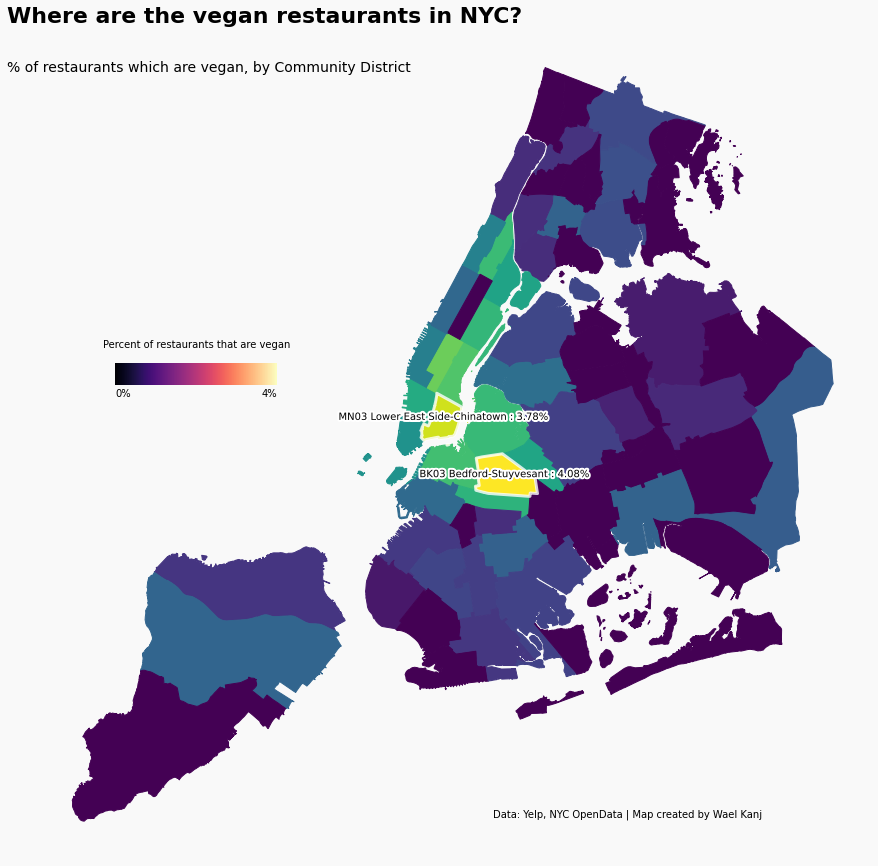

In [ ]:
plt.rcParams["figure.figsize"] = (15,15) # set this once for the rest of the notebook to increase the size of output plots unless specified elsewhere

fig, ax = plt.subplots()


fig.set_facecolor("#f9f9f9")
cdtas_restaurants_acs["Percent Vegan Restaurants"] = cdtas_restaurants_acs["VeganRatio"] * 100

cdtas_restaurants_acs.plot(ax = ax, column = "Percent Vegan Restaurants", edgecolors = "face", alpha = 1, cmap = 'viridis', 
                       legend = False) 

#colorbar
cbaxes = fig.add_axes([0.2, 0.5, 0.15, 0.02]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap="magma")                      
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,ticks=[0.05,0.95])
cb.set_ticklabels(["0%","4%"])
cb.outline.set_visible(False)
cbaxes.tick_params(size=0)
cbaxes.text(0.5, 1.7, "Percent of restaurants that are vegan", ha="center", size=10)

pd.options.mode.chained_assignment = None  # default='warn'

ax.axis('off')
plt.figtext(0.1, .85, "Where are the vegan restaurants in NYC?", va='top', fontsize=22, fontweight = "bold")
plt.figtext(0.1, .80, "% of restaurants that are vegan, by Community District", va='top', fontsize=14)
plt.figtext(0.55, .10, "Data: Yelp, NYC OpenData | Map created by Wael Kanj")

plt.subplots_adjust(bottom=0.01)

#plot highest percentage CDs

highest_percentages = cdtas_restaurants_acs.nlargest(2,"Percent Vegan Restaurants")
highest_percentages = highest_percentages.to_crs('EPSG:2263')
highest_percentages['coords'] = highest_percentages['geometry'].apply(lambda x: x.representative_point().coords[:])
highest_percentages['coords'] = [coords[0] for coords in highest_percentages['coords']] # eliminate duplicate points

highest_percentages.plot(ax = ax, facecolor="none", edgecolor = 'white', linewidth = 3, alpha = .8)
highest_percentages.apply(lambda x: ax.annotate(s=x['cdtaname'].split('(')[0] + ": " + "%.2f" % x['Percent Vegan Restaurants'] + "%", xy=x.geometry.centroid.coords[0], ha='center',color='black', path_effects=[pe.withStroke(linewidth=4, foreground="white")]), axis=1);

plt.savefig("/vegan-restaurants-nyc.png", dpi=300, bbox_inches="tight")

plt.show()
